# 第4章补充：自动微分引擎与梯度流可视化

> **学习目标：**
> - 理解前向模式与反向模式自动微分的区别
> - 掌握雅可比矩阵与向量积（JVP/VJP）的概念
> - 从零实现一个简单的自动微分引擎
> - 学会可视化神经网络中的梯度流
>
> **前置知识：** 04_backpropagation_implementation.ipynb 的内容
>
> **学习时间：** 3-4小时

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',
    'PingFang SC',
    'STHeiti',
    'Heiti TC',
    'SimHei',
]
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成！")

环境配置完成！


---

## 1. 自动微分概述

### 1.1 三种求导方式

| 方法 | 原理 | 优点 | 缺点 |
|------|------|------|------|
| **符号微分** | 直接对表达式求导 | 精确 | 表达式膨胀 |
| **数值微分** | 有限差分近似 | 简单 | 精度低、慢 |
| **自动微分** | 链式法则+计算图 | 精确、高效 | 实现复杂 |

### 1.2 自动微分的两种模式

**前向模式（Forward Mode）**：
- 沿着计算图的前向方向传播导数
- 一次前向传播计算一个输入变量对所有输出的导数
- 适合：输入少、输出多的情况

**反向模式（Reverse Mode）**：
- 沿着计算图的反向方向传播导数
- 一次反向传播计算一个输出对所有输入的导数
- 适合：输出少、输入多的情况（神经网络！）

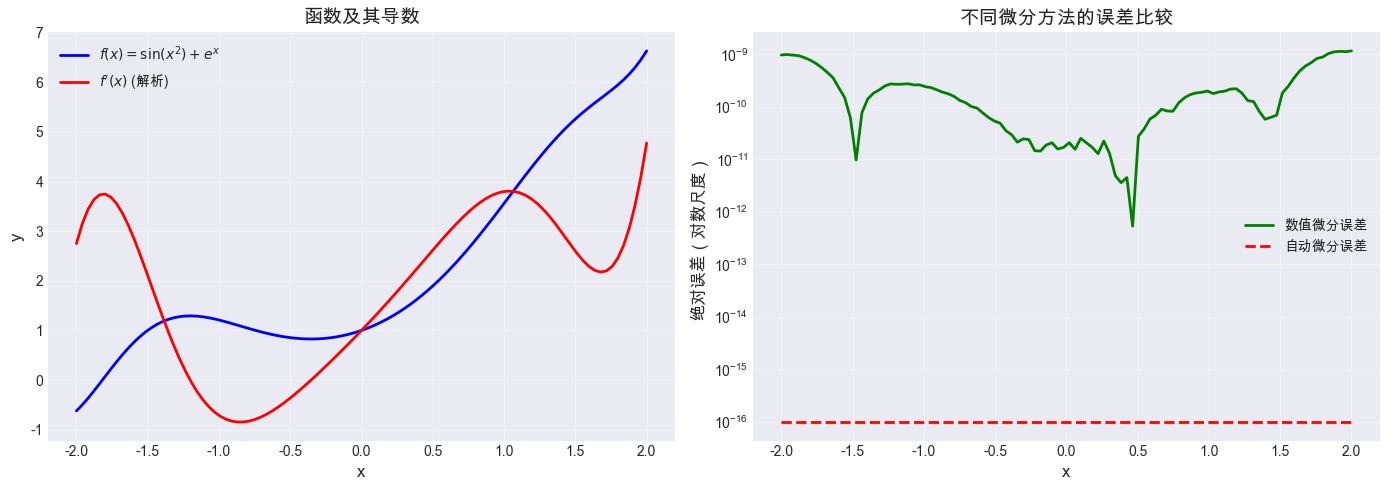


关键观察：
- 数值微分有截断误差（约1e-10量级）
- 自动微分在数值精度范围内是精确的
- 自动微分避免了表达式膨胀问题


In [2]:
def demonstrate_differentiation_methods():
    """
    演示三种微分方法
    
    目标函数: f(x) = sin(x^2) + exp(x)
    解析导数: f'(x) = 2x*cos(x^2) + exp(x)
    """
    # 目标函数
    def f(x):
        return np.sin(x**2) + np.exp(x)
    
    # 解析导数（符号微分的结果）
    def f_derivative_symbolic(x):
        return 2 * x * np.cos(x**2) + np.exp(x)
    
    # 数值微分
    def f_derivative_numerical(x, eps=1e-5):
        return (f(x + eps) - f(x - eps)) / (2 * eps)
    
    # 自动微分（前向模式）
    def f_derivative_forward_mode(x):
        """
        前向模式自动微分
        
        每个中间变量同时计算值和导数：(v, dv/dx)
        
        计算图分解:
            v1 = x          -> dv1/dx = 1
            v2 = v1^2       -> dv2/dx = 2*v1 * dv1/dx = 2x
            v3 = sin(v2)    -> dv3/dx = cos(v2) * dv2/dx = 2x*cos(x^2)
            v4 = exp(v1)    -> dv4/dx = exp(v1) * dv1/dx = exp(x)
            f = v3 + v4     -> df/dx = dv3/dx + dv4/dx
        """
        # 前向传播，同时计算值和导数
        v1, dv1 = x, 1.0  # v1 = x, dv1/dx = 1
        v2, dv2 = v1**2, 2*v1*dv1  # v2 = v1^2
        v3, dv3 = np.sin(v2), np.cos(v2)*dv2  # v3 = sin(v2)
        v4, dv4 = np.exp(v1), np.exp(v1)*dv1  # v4 = exp(v1)
        f_val, df = v3 + v4, dv3 + dv4  # f = v3 + v4
        return df
    
    # 测试
    x_test = np.linspace(-2, 2, 100)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：函数及其导数
    ax1 = axes[0]
    ax1.plot(x_test, f(x_test), 'b-', linewidth=2, label='$f(x) = \sin(x^2) + e^x$')
    ax1.plot(x_test, f_derivative_symbolic(x_test), 'r-', linewidth=2, label="$f'(x)$ (解析)")
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('y', fontsize=12)
    ax1.set_title('函数及其导数', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 右图：三种方法的误差比较
    ax2 = axes[1]
    
    symbolic = f_derivative_symbolic(x_test)
    numerical = np.array([f_derivative_numerical(x) for x in x_test])
    forward = np.array([f_derivative_forward_mode(x) for x in x_test])
    
    ax2.semilogy(x_test, np.abs(numerical - symbolic), 'g-', linewidth=2, 
                  label='数值微分误差')
    ax2.semilogy(x_test, np.abs(forward - symbolic) + 1e-16, 'r--', linewidth=2, 
                  label='自动微分误差')
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('绝对误差（对数尺度）', fontsize=12)
    ax2.set_title('不同微分方法的误差比较', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n关键观察：")
    print("- 数值微分有截断误差（约1e-10量级）")
    print("- 自动微分在数值精度范围内是精确的")
    print("- 自动微分避免了表达式膨胀问题")

demonstrate_differentiation_methods()

---

## 2. 雅可比矩阵与向量积（JVP/VJP）

### 2.1 雅可比矩阵

对于函数 $\mathbf{f}: \mathbb{R}^n \to \mathbb{R}^m$，雅可比矩阵定义为：

$$J = \frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n}
\end{bmatrix}$$

### 2.2 JVP（Jacobian-Vector Product）

**JVP = 雅可比矩阵 × 向量**（前向模式计算）

$$\text{JVP}(\mathbf{v}) = J \cdot \mathbf{v}$$

- 输入：切向量 $\mathbf{v} \in \mathbb{R}^n$
- 输出：$J\mathbf{v} \in \mathbb{R}^m$
- 复杂度：O(m)，与输出维度成正比

### 2.3 VJP（Vector-Jacobian Product）

**VJP = 向量 × 雅可比矩阵**（反向模式计算）

$$\text{VJP}(\mathbf{v}) = \mathbf{v}^T \cdot J = (J^T \mathbf{v})^T$$

- 输入：余切向量 $\mathbf{v} \in \mathbb{R}^m$
- 输出：$\mathbf{v}^T J \in \mathbb{R}^n$
- 复杂度：O(n)，与输入维度成正比

In [3]:
def demonstrate_jvp_vjp():
    """
    演示JVP和VJP的计算
    
    考虑函数 f: R^2 -> R^3
    f(x, y) = [x^2 + y, xy, sin(x)]
    
    雅可比矩阵:
    J = [[2x, 1],
         [y,  x],
         [cos(x), 0]]
    """
    def f(x, y):
        """f: R^2 -> R^3"""
        return np.array([x**2 + y, x*y, np.sin(x)])
    
    def jacobian(x, y):
        """解析雅可比矩阵"""
        return np.array([
            [2*x, 1],
            [y, x],
            [np.cos(x), 0]
        ])
    
    def jvp(x, y, v):
        """
        JVP: J @ v
        
        前向模式：同时传播值和切向量
        
        参数:
            x, y: 输入点
            v: 切向量 (2,)
        
        返回:
            J @ v (3,)
        """
        v_x, v_y = v  # 输入的切向量分量
        
        # 前向传播，同时计算值和切向量
        # f1 = x^2 + y
        # df1 = 2x*dx + 1*dy = 2x*v_x + v_y
        df1 = 2*x*v_x + v_y
        
        # f2 = x*y
        # df2 = y*dx + x*dy = y*v_x + x*v_y
        df2 = y*v_x + x*v_y
        
        # f3 = sin(x)
        # df3 = cos(x)*dx = cos(x)*v_x
        df3 = np.cos(x)*v_x
        
        return np.array([df1, df2, df3])
    
    def vjp(x, y, v):
        """
        VJP: v.T @ J = J.T @ v
        
        反向模式：从输出向输入传播梯度
        
        参数:
            x, y: 输入点
            v: 余切向量 (3,)
        
        返回:
            v.T @ J (2,)
        """
        v1, v2, v3 = v  # 输出的余切向量（梯度）分量
        
        # 反向传播梯度到输入
        # dx = v1 * df1/dx + v2 * df2/dx + v3 * df3/dx
        #    = v1 * 2x + v2 * y + v3 * cos(x)
        dx = v1 * 2*x + v2 * y + v3 * np.cos(x)
        
        # dy = v1 * df1/dy + v2 * df2/dy + v3 * df3/dy
        #    = v1 * 1 + v2 * x + v3 * 0
        dy = v1 * 1 + v2 * x + 0
        
        return np.array([dx, dy])
    
    # 测试点
    x, y = 2.0, 3.0
    J = jacobian(x, y)
    
    print("函数 f(x, y) = [x² + y, xy, sin(x)]")
    print(f"\n测试点: (x, y) = ({x}, {y})")
    print(f"\n雅可比矩阵 J (3×2):\n{J}")
    
    # 测试JVP
    v_in = np.array([1.0, 0.0])  # 切向量
    jvp_direct = J @ v_in
    jvp_computed = jvp(x, y, v_in)
    
    print(f"\n=== JVP (前向模式) ===")
    print(f"输入切向量 v = {v_in}")
    print(f"直接计算 J @ v = {jvp_direct}")
    print(f"前向模式计算 = {jvp_computed}")
    print(f"一致性检查: {np.allclose(jvp_direct, jvp_computed)}")
    
    # 测试VJP
    v_out = np.array([1.0, 1.0, 1.0])  # 余切向量
    vjp_direct = v_out @ J
    vjp_computed = vjp(x, y, v_out)
    
    print(f"\n=== VJP (反向模式) ===")
    print(f"输入余切向量 v = {v_out}")
    print(f"直接计算 v.T @ J = {vjp_direct}")
    print(f"反向模式计算 = {vjp_computed}")
    print(f"一致性检查: {np.allclose(vjp_direct, vjp_computed)}")
    
    print("\n\n关键理解：")
    print("- JVP: 一次计算一个输入变量对所有输出的影响")
    print("- VJP: 一次计算一个输出对所有输入的梯度")
    print("- 神经网络：输入多（参数）、输出少（损失）→ 用VJP（反向传播）更高效！")

demonstrate_jvp_vjp()

函数 f(x, y) = [x² + y, xy, sin(x)]

测试点: (x, y) = (2.0, 3.0)

雅可比矩阵 J (3×2):
[[ 4.          1.        ]
 [ 3.          2.        ]
 [-0.41614684  0.        ]]

=== JVP (前向模式) ===
输入切向量 v = [1. 0.]
直接计算 J @ v = [ 4.          3.         -0.41614684]
前向模式计算 = [ 4.          3.         -0.41614684]
一致性检查: True

=== VJP (反向模式) ===
输入余切向量 v = [1. 1. 1.]
直接计算 v.T @ J = [6.58385316 3.        ]
反向模式计算 = [6.58385316 3.        ]
一致性检查: True


关键理解：
- JVP: 一次计算一个输入变量对所有输出的影响
- VJP: 一次计算一个输出对所有输入的梯度
- 神经网络：输入多（参数）、输出少（损失）→ 用VJP（反向传播）更高效！


---

## 3. 从零实现自动微分引擎

### 3.1 设计思路

我们将实现一个类似PyTorch的反向模式自动微分引擎：

1. **Value类**：包装标量值，记录计算历史
2. **计算图**：自动构建，记录操作和依赖关系
3. **反向传播**：拓扑排序后从输出向输入传播梯度

In [4]:
class Value:
    """
    自动微分引擎的核心类 - 从零实现
    
    类似于PyTorch的Tensor（简化版，只支持标量）
    
    核心功能:
        - 包装数值，支持基本数学运算
        - 自动构建计算图
        - 支持反向传播计算梯度
    
    属性:
        data: float, 实际的数值
        grad: float, 梯度值（反向传播后填充）
        _backward: function, 局部反向传播函数
        _prev: set, 前驱节点（用于构建计算图）
        _op: str, 产生此节点的操作名称
    """
    
    def __init__(self, data, _children=(), _op='', label=''):
        """
        初始化Value节点
        
        参数:
            data: float, 数值
            _children: tuple, 前驱节点（用于反向传播）
            _op: str, 操作名称（用于可视化）
            label: str, 节点标签（用于可视化）
        """
        self.data = data
        self.grad = 0.0  # 梯度初始化为0
        self._backward = lambda: None  # 默认的反向传播函数（什么都不做）
        self._prev = set(_children)  # 前驱节点集合
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
    
    def __add__(self, other):
        """
        加法: self + other
        
        前向: out = self.data + other.data
        反向: d(out)/d(self) = 1, d(out)/d(other) = 1
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # 链式法则：将输出的梯度传递给输入
            # d(L)/d(self) = d(L)/d(out) * d(out)/d(self) = out.grad * 1
            self.grad += out.grad  # 注意是 +=，因为一个节点可能被多次使用
            other.grad += out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        """
        乘法: self * other
        
        前向: out = self.data * other.data
        反向: d(out)/d(self) = other.data, d(out)/d(other) = self.data
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, n):
        """
        幂运算: self ** n
        
        前向: out = self.data ^ n
        反向: d(out)/d(self) = n * self.data^(n-1)
        """
        assert isinstance(n, (int, float)), "幂次必须是常数"
        out = Value(self.data ** n, (self,), f'**{n}')
        
        def _backward():
            self.grad += n * (self.data ** (n - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __neg__(self):
        """取负: -self"""
        return self * -1
    
    def __sub__(self, other):
        """减法: self - other"""
        return self + (-other)
    
    def __truediv__(self, other):
        """除法: self / other"""
        return self * (other ** -1)
    
    def __radd__(self, other):
        """反向加法: other + self"""
        return self + other
    
    def __rmul__(self, other):
        """反向乘法: other * self"""
        return self * other
    
    def __rsub__(self, other):
        """反向减法: other - self"""
        return (-self) + other
    
    def __rtruediv__(self, other):
        """反向除法: other / self"""
        return other * (self ** -1)
    
    def tanh(self):
        """
        Tanh激活函数
        
        前向: out = tanh(self.data)
        反向: d(out)/d(self) = 1 - tanh^2(self.data) = 1 - out^2
        """
        t = np.tanh(self.data)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def relu(self):
        """
        ReLU激活函数
        
        前向: out = max(0, self.data)
        反向: d(out)/d(self) = 1 if self.data > 0 else 0
        """
        out = Value(max(0, self.data), (self,), 'ReLU')
        
        def _backward():
            self.grad += (self.data > 0) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        """
        指数函数
        
        前向: out = exp(self.data)
        反向: d(out)/d(self) = exp(self.data) = out
        """
        e = np.exp(self.data)
        out = Value(e, (self,), 'exp')
        
        def _backward():
            self.grad += e * out.grad
        
        out._backward = _backward
        return out
    
    def log(self):
        """
        自然对数
        
        前向: out = log(self.data)
        反向: d(out)/d(self) = 1 / self.data
        """
        out = Value(np.log(self.data), (self,), 'log')
        
        def _backward():
            self.grad += (1 / self.data) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        """
        反向传播：计算所有节点的梯度
        
        算法：
        1. 拓扑排序：确保在处理一个节点之前，其所有后继节点都已处理
        2. 从输出向输入传播梯度
        """
        # 拓扑排序
        topo = []  # 拓扑排序结果
        visited = set()
        
        def build_topo(v):
            """深度优先搜索构建拓扑排序"""
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        # 从输出开始，梯度为1
        self.grad = 1.0
        
        # 按拓扑排序的逆序执行反向传播
        for v in reversed(topo):
            v._backward()


print("Value类定义完成！")

Value类定义完成！


In [5]:
# 测试自动微分引擎
def test_autograd():
    """
    测试自动微分引擎的正确性
    """
    print("=" * 60)
    print("自动微分引擎测试")
    print("=" * 60)
    
    # 测试1：简单表达式
    # f = (x + y) * z
    # df/dx = z, df/dy = z, df/dz = x + y
    print("\n测试1: f = (x + y) * z")
    x = Value(2.0, label='x')
    y = Value(3.0, label='y')
    z = Value(4.0, label='z')
    f = (x + y) * z
    f.backward()
    
    print(f"  x = {x.data}, y = {y.data}, z = {z.data}")
    print(f"  f = {f.data}")
    print(f"  df/dx = {x.grad} (期望: {z.data})")
    print(f"  df/dy = {y.grad} (期望: {z.data})")
    print(f"  df/dz = {z.grad} (期望: {x.data + y.data})")
    
    # 测试2：更复杂的表达式
    # f = x^2 + 2*x*y + y^2 = (x + y)^2
    # df/dx = 2(x+y), df/dy = 2(x+y)
    print("\n测试2: f = x² + 2xy + y²")
    x = Value(3.0, label='x')
    y = Value(2.0, label='y')
    f = x**2 + 2*x*y + y**2
    f.backward()
    
    print(f"  x = {x.data}, y = {y.data}")
    print(f"  f = {f.data} (期望: {(x.data + y.data)**2})")
    print(f"  df/dx = {x.grad} (期望: {2*(x.data + y.data)})")
    print(f"  df/dy = {y.grad} (期望: {2*(x.data + y.data)})")
    
    # 测试3：带激活函数
    # f = tanh(x*w + b)
    print("\n测试3: f = tanh(x*w + b) - 神经元")
    x = Value(1.0, label='x')
    w = Value(2.0, label='w')
    b = Value(0.5, label='b')
    z = x * w + b
    f = z.tanh()
    f.backward()
    
    # 解析计算
    z_val = x.data * w.data + b.data
    tanh_val = np.tanh(z_val)
    dtanh = 1 - tanh_val**2
    
    print(f"  x = {x.data}, w = {w.data}, b = {b.data}")
    print(f"  f = tanh({z_val}) = {f.data:.6f} (期望: {tanh_val:.6f})")
    print(f"  df/dw = {w.grad:.6f} (期望: {x.data * dtanh:.6f})")
    print(f"  df/db = {b.grad:.6f} (期望: {dtanh:.6f})")

test_autograd()

自动微分引擎测试

测试1: f = (x + y) * z
  x = 2.0, y = 3.0, z = 4.0
  f = 20.0
  df/dx = 4.0 (期望: 4.0)
  df/dy = 4.0 (期望: 4.0)
  df/dz = 5.0 (期望: 5.0)

测试2: f = x² + 2xy + y²
  x = 3.0, y = 2.0
  f = 25.0 (期望: 25.0)
  df/dx = 10.0 (期望: 10.0)
  df/dy = 10.0 (期望: 10.0)

测试3: f = tanh(x*w + b) - 神经元
  x = 1.0, w = 2.0, b = 0.5
  f = tanh(2.5) = 0.986614 (期望: 0.986614)
  df/dw = 0.026592 (期望: 0.026592)
  df/db = 0.026592 (期望: 0.026592)


### 3.2 使用自动微分引擎构建神经网络

In [6]:
class Neuron:
    """
    单个神经元
    
    计算: out = activation(sum(w_i * x_i) + b)
    """
    
    def __init__(self, n_inputs, activation='tanh'):
        """
        初始化神经元
        
        参数:
            n_inputs: int, 输入特征数
            activation: str, 激活函数类型
        """
        # 随机初始化权重和偏置
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(np.random.uniform(-1, 1))
        self.activation = activation
    
    def __call__(self, x):
        """前向传播"""
        # 加权和
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # 激活函数
        if self.activation == 'tanh':
            return act.tanh()
        elif self.activation == 'relu':
            return act.relu()
        else:
            return act  # 线性
    
    def parameters(self):
        """返回所有可训练参数"""
        return self.w + [self.b]


class Layer:
    """
    神经网络层（多个神经元）
    """
    
    def __init__(self, n_inputs, n_outputs, activation='tanh'):
        """
        初始化层
        
        参数:
            n_inputs: int, 输入特征数
            n_outputs: int, 输出特征数（神经元数量）
            activation: str, 激活函数类型
        """
        self.neurons = [Neuron(n_inputs, activation) for _ in range(n_outputs)]
    
    def __call__(self, x):
        """前向传播"""
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        """返回所有可训练参数"""
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    """
    多层感知机（使用自动微分引擎）
    """
    
    def __init__(self, n_inputs, n_outputs_list):
        """
        初始化MLP
        
        参数:
            n_inputs: int, 输入特征数
            n_outputs_list: list, 每层的输出数量
                例如 [16, 16, 1] 表示两个隐藏层各16个神经元，输出层1个神经元
        """
        sizes = [n_inputs] + n_outputs_list
        self.layers = []
        for i in range(len(n_outputs_list)):
            # 最后一层不用激活函数（或者用线性）
            act = 'tanh' if i < len(n_outputs_list) - 1 else 'linear'
            self.layers.append(Layer(sizes[i], sizes[i+1], act))
    
    def __call__(self, x):
        """前向传播"""
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        """返回所有可训练参数"""
        return [p for layer in self.layers for p in layer.parameters()]


print("神经网络类定义完成！")

神经网络类定义完成！


使用自动微分引擎训练MLP
模型参数数量: 37
Epoch   0: Loss = 4.674255
Epoch  20: Loss = 0.242444
Epoch  40: Loss = 0.211723
Epoch  60: Loss = 0.175555
Epoch  80: Loss = 0.135915
Epoch  99: Loss = 0.098875


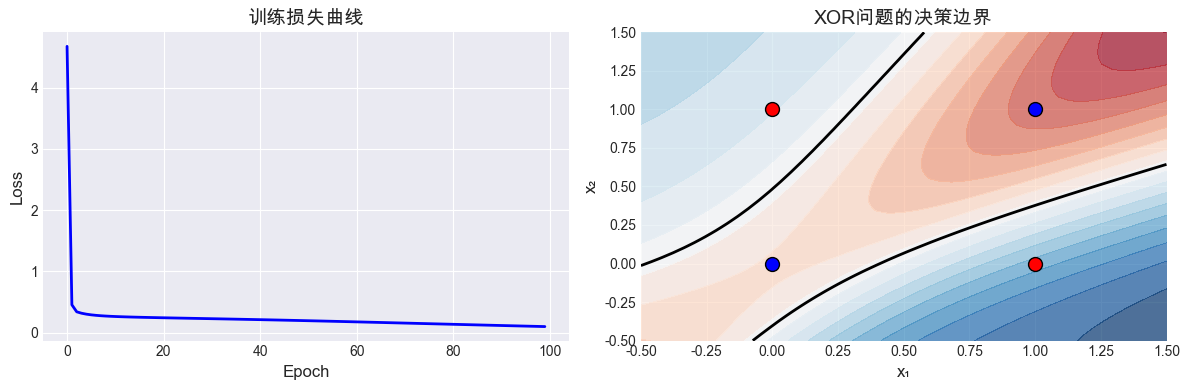


最终预测:
  输入: [0.0, 0.0] -> 预测: 0.4135, 真实: 0.0
  输入: [0.0, 1.0] -> 预测: 0.6039, 真实: 1.0
  输入: [1.0, 0.0] -> 预测: 0.8059, 真实: 1.0
  输入: [1.0, 1.0] -> 预测: 0.1496, 真实: 0.0


In [7]:
# 使用自动微分引擎训练神经网络
def train_mlp_demo():
    """
    演示使用自动微分引擎训练神经网络
    """
    print("=" * 60)
    print("使用自动微分引擎训练MLP")
    print("=" * 60)
    
    # 简单的二分类数据
    # XOR问题
    X = [
        [0.0, 0.0],
        [0.0, 1.0],
        [1.0, 0.0],
        [1.0, 1.0]
    ]
    y = [0.0, 1.0, 1.0, 0.0]  # XOR标签
    
    # 创建模型
    np.random.seed(42)
    model = MLP(2, [4, 4, 1])  # 2输入 -> 4 -> 4 -> 1输出
    
    n_params = len(model.parameters())
    print(f"模型参数数量: {n_params}")
    
    # 训练
    learning_rate = 0.1
    n_epochs = 100
    losses = []
    
    for epoch in range(n_epochs):
        # 前向传播
        preds = [model([Value(xi) for xi in x]) for x in X]
        
        # 计算MSE损失
        loss = sum((pred - yi)**2 for pred, yi in zip(preds, y)) / len(y)
        
        losses.append(loss.data)
        
        # 清零梯度
        for p in model.parameters():
            p.grad = 0.0
        
        # 反向传播
        loss.backward()
        
        # 更新参数
        for p in model.parameters():
            p.data -= learning_rate * p.grad
        
        if epoch % 20 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch:3d}: Loss = {loss.data:.6f}")
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # 损失曲线
    ax1 = axes[0]
    ax1.plot(losses, 'b-', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('训练损失曲线', fontsize=14)
    
    # 决策边界
    ax2 = axes[1]
    
    # 创建网格
    xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 50), np.linspace(-0.5, 1.5, 50))
    Z = np.zeros_like(xx)
    
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            pred = model([Value(xx[i, j]), Value(yy[i, j])])
            Z[i, j] = pred.data
    
    ax2.contourf(xx, yy, Z, levels=20, cmap='RdBu', alpha=0.7)
    ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # 绘制数据点
    for xi, yi in zip(X, y):
        color = 'red' if yi == 1 else 'blue'
        ax2.scatter(xi[0], xi[1], c=color, s=100, edgecolors='black', zorder=5)
    
    ax2.set_xlabel('x₁', fontsize=12)
    ax2.set_ylabel('x₂', fontsize=12)
    ax2.set_title('XOR问题的决策边界', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # 打印最终预测
    print("\n最终预测:")
    for xi, yi in zip(X, y):
        pred = model([Value(xi[0]), Value(xi[1])])
        print(f"  输入: {xi} -> 预测: {pred.data:.4f}, 真实: {yi}")

train_mlp_demo()

---

## 4. 梯度流可视化

### 4.1 什么是梯度流？

**梯度流（Gradient Flow）**描述梯度在网络中的传播情况：
- 梯度太小：梯度消失，深层网络难以训练
- 梯度太大：梯度爆炸，训练不稳定
- 理想情况：梯度保持稳定的幅度

In [ ]:
def visualize_gradient_flow():
    """
    可视化神经网络中的梯度流
    
    比较不同激活函数下梯度的传播情况
    """
    def compute_gradients(activation, n_layers=10, n_neurons=10):
        """
        计算一个深层网络各层的平均梯度幅度
        """
        np.random.seed(42)
        
        # 构建深层网络
        layers = []
        for i in range(n_layers):
            n_in = 1 if i == 0 else n_neurons
            n_out = 1 if i == n_layers - 1 else n_neurons
            act = activation if i < n_layers - 1 else 'linear'
            layers.append(Layer(n_in, n_out, act))
        
        # 前向传播
        x = [Value(1.0)]
        for layer in layers:
            x = layer(x) if isinstance(layer(x), list) else [layer(x)]
        
        # 假设输出对损失的梯度为1
        loss = x[0]
        
        # 反向传播
        for layer in layers:
            for p in layer.parameters():
                p.grad = 0.0
        
        loss.backward()
        
        # 收集每层的梯度幅度
        grad_magnitudes = []
        for layer in layers:
            layer_grads = [abs(p.grad) for p in layer.parameters()]
            grad_magnitudes.append(np.mean(layer_grads))
        
        return grad_magnitudes
    
    # 比较不同激活函数
    activations = ['tanh', 'relu']
    n_layers = 10
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for act in activations:
        grads = compute_gradients(act, n_layers=n_layers)
        ax.semilogy(range(1, n_layers + 1), grads, 'o-', linewidth=2, 
                     markersize=8, label=act.upper())
    
    ax.set_xlabel('层编号（1=最接近输入）', fontsize=12)
    ax.set_ylabel('平均梯度幅度（对数尺度）', fontsize=12)
    ax.set_title(f'{n_layers}层网络的梯度流', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n观察：")
    print("- Tanh: 梯度在传播过程中可能衰减（梯度消失）")
    print("- ReLU: 梯度传播更稳定（但可能有Dead ReLU问题）")

visualize_gradient_flow()

In [ ]:
def visualize_gradient_distribution():
    """
    可视化不同层的梯度分布
    """
    np.random.seed(42)
    
    # 创建一个更大的网络用于统计
    n_layers = 5
    n_neurons = 20
    n_samples = 50  # 运行多次以获得梯度分布
    
    layer_grads = {i: [] for i in range(n_layers)}
    
    for _ in range(n_samples):
        # 构建网络
        layers = []
        for i in range(n_layers):
            n_in = 2 if i == 0 else n_neurons
            n_out = 1 if i == n_layers - 1 else n_neurons
            act = 'tanh' if i < n_layers - 1 else 'linear'
            layers.append(Layer(n_in, n_out, act))
        
        # 随机输入
        x = [Value(np.random.randn()), Value(np.random.randn())]
        
        # 前向传播
        for layer in layers:
            x = layer(x) if isinstance(layer(x), list) else [layer(x)]
        
        loss = x[0]
        
        # 清零梯度
        for layer in layers:
            for p in layer.parameters():
                p.grad = 0.0
        
        # 反向传播
        loss.backward()
        
        # 收集梯度
        for i, layer in enumerate(layers):
            grads = [p.grad for p in layer.parameters()]
            layer_grads[i].extend(grads)
    
    # 可视化
    fig, axes = plt.subplots(1, n_layers, figsize=(15, 4))
    
    for i in range(n_layers):
        ax = axes[i]
        grads = layer_grads[i]
        ax.hist(grads, bins=30, density=True, alpha=0.7, color='blue')
        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_xlabel('梯度值', fontsize=10)
        ax.set_ylabel('密度', fontsize=10)
        ax.set_title(f'Layer {i+1}\nmean={np.mean(grads):.4f}\nstd={np.std(grads):.4f}', fontsize=10)
    
    plt.suptitle('各层梯度分布', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_gradient_distribution()

---

## 5. 总结与要点

### 5.1 自动微分的核心概念

| 概念 | 说明 |
|------|------|
| 计算图 | 记录前向传播的操作序列 |
| 链式法则 | 梯度的乘法传播规则 |
| JVP | 前向模式：一次计算一个输入变量的影响 |
| VJP | 反向模式：一次计算一个输出的梯度 |

### 5.2 为什么深度学习用反向模式？

神经网络的特点：
- 输入（参数）：数百万到数十亿
- 输出（损失）：通常只有1个标量

因此：
- 前向模式：需要运行N次前向传播（N=参数数量）→ 太慢！
- 反向模式：只需1次反向传播 → 高效！

### 5.3 梯度流的重要性

1. **梯度消失**：梯度在深层网络中指数衰减
2. **梯度爆炸**：梯度在深层网络中指数增长
3. **解决方案**：残差连接、BatchNorm、合适的初始化等

---

## 6. 练习题

### 练习1：扩展Value类

为Value类添加sin和cos函数的支持。

### 练习2：实现一个简单的优化器

基于Value类实现SGD和Adam优化器。

### 练习3（挑战）：计算图可视化

实现一个函数，将Value对象的计算图可视化（类似PyTorch的torchviz）。

In [ ]:
# 练习答案区域

def exercise_1_sin_cos():
    """
    练习1: 为Value类添加sin和cos
    """
    # 在Value类中添加以下方法:
    
    def sin(self):
        """
        正弦函数
        前向: out = sin(self.data)
        反向: d(out)/d(self) = cos(self.data)
        """
        out = Value(np.sin(self.data), (self,), 'sin')
        
        def _backward():
            self.grad += np.cos(self.data) * out.grad
        
        out._backward = _backward
        return out
    
    def cos(self):
        """
        余弦函数
        前向: out = cos(self.data)
        反向: d(out)/d(self) = -sin(self.data)
        """
        out = Value(np.cos(self.data), (self,), 'cos')
        
        def _backward():
            self.grad += -np.sin(self.data) * out.grad
        
        out._backward = _backward
        return out
    
    # 添加到Value类
    Value.sin = sin
    Value.cos = cos
    
    # 测试
    x = Value(np.pi / 4)
    y = x.sin()
    y.backward()
    
    print("测试 sin:")
    print(f"  x = π/4 = {x.data:.6f}")
    print(f"  sin(x) = {y.data:.6f} (期望: {np.sin(np.pi/4):.6f})")
    print(f"  d(sin(x))/dx = {x.grad:.6f} (期望: {np.cos(np.pi/4):.6f})")

exercise_1_sin_cos()

---

## 参考资料

1. **自动微分**: Baydin et al., "Automatic Differentiation in Machine Learning: a Survey" (2018)
2. **micrograd**: Andrej Karpathy's minimalist autograd engine (GitHub)
3. **JAX**: Google's autograd library with JVP/VJP support
4. **PyTorch Autograd**: Official PyTorch documentation

---

**下一章预告**: 07b_normalization_variants.ipynb - 归一化变种与残差连接